In [1]:
import pandas as pd
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Задание 
* Обучить логистическую регрессию на своих данных, подобрать параметры.
* Сравнить результаты применения L_1L и L_2L регуляризаций. 
  Посмотреть веса признаков, объяснить полученные значения.
* Провести отбор признаков с помощью L_1L регуляризации, подобрать оптимальный C, объяснить результат.

### Предобработка

In [2]:
raw_data = pd.read_csv("Pokemon.csv",index_col = 1)
raw_data.drop("#",axis = 1,inplace = True)

In [3]:
types = raw_data["Type 2"].value_counts().index

raw_data["No second type"] = raw_data["Type 2"].apply(lambda x: 1 if pd.isnull(x) else 0)

for pokemon_type in types:
    raw_data[pokemon_type] = raw_data["Type 1"].apply(lambda x: 1 if x == pokemon_type else 0)
    raw_data.loc[raw_data["Type 2"] == pokemon_type,pokemon_type] = raw_data.loc[raw_data["Type 2"] == pokemon_type,
                                                                                 pokemon_type].apply(lambda x: 1)
raw_data["Legendary"] = raw_data["Legendary"].apply(lambda x: 1 if x  else 0)

In [4]:
Legendary = raw_data["Legendary"]
raw_data = raw_data.drop("Legendary",axis = 1)
raw_data["Legendary"] = Legendary

raw_data = raw_data.drop(["Type 1","Type 2"],axis = 1)

In [5]:
raw_data.head()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,No second type,Flying,...,Dragon,Ice,Water,Ghost,Rock,Fire,Electric,Normal,Bug,Legendary
Name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,318,45,49,49,65,65,45,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Ivysaur,405,60,62,63,80,80,60,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Venusaur,525,80,82,83,100,100,80,1,0,0,...,0,0,0,0,0,0,0,0,0,0
VenusaurMega Venusaur,625,80,100,123,122,120,80,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Charmander,309,39,52,43,60,50,65,1,1,0,...,0,0,0,0,0,1,0,0,0,0


In [6]:
from sklearn.utils import shuffle
raw_data = shuffle(raw_data,random_state = 0)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
Xtr_source,Xtst_source,ytr_source,ytst_source = train_test_split(raw_data.drop("Legendary",axis = 1),raw_data["Legendary"],
                                   test_size = 0.33,random_state = 0)

Train_source,Test_source,y_train,y_test = train_test_split(raw_data.drop("Legendary",axis = 1),raw_data["Legendary"],
                                   test_size = 0.33,stratify = raw_data["Legendary"],random_state = 0)

In [9]:
from scipy.stats import iqr

false_legend = Train_source.loc[y_train == 0]

false_box_range = ((false_legend.HP.quantile([0.25,0.75])).values[0] - 1.5*iqr(false_legend.HP),
             (false_legend.HP.quantile([0.25,0.75])).values[1] + 1.5*iqr(false_legend.HP))

true_legend = Train_source.loc[y_train == 1]
true_box_range = ((true_legend.HP.quantile([0.25,0.75])).values[0] - 1.5*iqr(true_legend.HP),
             (true_legend.HP.quantile([0.25,0.75])).values[1] + 1.5*iqr(true_legend.HP))

In [10]:
indexes = Train_source.loc[Train_source.HP > false_box_range[1]].index
Train_source.drop(indexes,axis = 0,inplace = True)
y_train.drop(indexes,axis = 0,inplace = True)

Train_source.drop(Train_source.loc[Train_source.HP > false_box_range[1]].index,axis = 0,inplace = True)
y_train.drop(Train_source.loc[Train_source.HP > false_box_range[1]].index,axis = 0,inplace = True)

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
feature_scale = Train_source.columns[:8].values
train_indexes = Train_source.index
scaler.fit(Train_source.loc[:,feature_scale])
Train_feature = scaler.transform(Train_source.loc[:,feature_scale])
df_feature = pd.DataFrame(Train_feature,index = train_indexes,columns = feature_scale)
nonscale = pd.DataFrame(Train_source.iloc[:,8:],index = train_indexes)

Train_data = pd.concat([df_feature,nonscale],axis = 1)

In [12]:
test_indexes = Test_source.index
Test_feature = scaler.transform(Test_source.loc[:,feature_scale])
df_feature_t = pd.DataFrame(Test_feature,index = test_indexes,columns = feature_scale)
nonscale_t = pd.DataFrame(Test_source.iloc[:,8:],index = test_indexes)

Test_data = pd.concat([df_feature_t,nonscale_t],axis = 1)

In [13]:
X_train = Train_data
X_test = Test_data

In [14]:
print ("Количество 1-го класса:",len(X_train[y_train.values == 1]))
print ("Количество 2-го класса:",len(X_train[y_train.values == 0]))

Количество 1-го класса: 41
Количество 2-го класса: 483


In [15]:
np.random.seed(0)
indices_to_add = np.random.randint(0,41,483-41)
indexes = np.arange(0,len(X_train),1)
X_train_to_add = X_train[y_train.values == 1].iloc[indices_to_add]
y_train_to_add = np.linspace(1,1,483 - 41)

X_train = pd.concat([X_train,X_train_to_add])
y_train  = np.hstack((y_train.values,y_train_to_add))

### Обучить логистическую регрессию на своих данных, подобрать параметры.

In [16]:
def plot_scores(optimizer):
    par_C = [row['C'] for row in optimizer.cv_results_['params']]
    test_score = optimizer.cv_results_['mean_test_score']
    std_test_score = optimizer.cv_results_['std_test_score']
    plt.fill_between(par_C, test_score-std_test_score,
    test_score+std_test_score, alpha=0.3)
    plt.semilogx(par_C, test_score)
    plt.show()

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [18]:
source_classifier = LogisticRegression(solver = 'liblinear')

classifier = LogisticRegression(penalty= "none",solver = 'lbfgs',max_iter=1000)
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3

grid_cv_1 = GridSearchCV(source_classifier,param_grid,cv = cv) 
grid_cv_1.fit(Xtr_source,ytr_source)

grid_cv_2 = GridSearchCV(classifier,param_grid,cv = cv) 
grid_cv_2.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_r

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='warn',
                                          n_jobs=None, penalty='none',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [19]:
def feat_coef(estimator):
    array = []
    for column,coef in zip(X_train.columns,estimator.coef_[0]):
        array.append((column,coef))
    array.sort(key = lambda x: x[1])  
    return array

Качество алгоритма до предобработки с l2 регуляризацией:


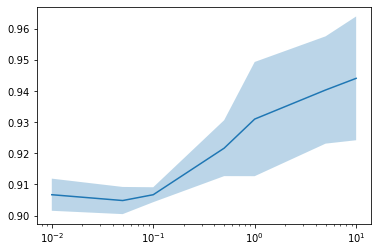

auc score :  0.9164086687306502
Качество алгоритма после предобработки без регуляризации:


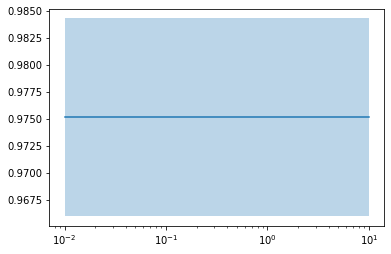

auc score :  0.974132863021752


In [20]:
print ("Качество алгоритма до предобработки с l2 регуляризацией:")
     
plot_scores(grid_cv_1)
print ("auc score : ",roc_auc_score(ytst_source,grid_cv_1.predict_proba(Xtst_source)[:,1]))

print ("Качество алгоритма после предобработки без регуляризации:")

plot_scores(grid_cv_2)
print ("auc score : ",roc_auc_score(y_test,grid_cv_2.predict_proba(X_test)[:,1]))
plt.show()

In [21]:
wo_reg = grid_cv_2.best_estimator_
print (feat_coef(wo_reg))

[('Poison', -24.0962608515516), ('Bug', -17.035777435647088), ('Ghost', -12.532125310591228), ('Normal', -7.252851356885932), ('Dark', -4.9549099425626935), ('Dragon', -4.61662647162898), ('Fairy', -3.7015870129543886), ('Fighting', -3.074496603445264), ('Water', -3.024687377547538), ('Ground', -1.713363063788536), ('Ice', -1.4437109910074866), ('Steel', -0.8348781710598423), ('Fire', -0.81942412302275), ('Grass', -0.7430306349310192), ('Electric', -0.29900764135066726), ('Psychic', 0.33520570617025053), ('Attack', 0.3553826910501841), ('Flying', 0.9948889075657555), ('No second type', 1.1610770695292718), ('Rock', 1.7182280746858747), ('Generation', 2.8554441329872615), ('Sp. Atk', 5.790279744288503), ('HP', 7.696057511521588), ('Defense', 8.706661407514696), ('Sp. Def', 10.43112591966547), ('Speed', 17.141899887831077), ('Total', 23.92087248488546)]


### Сравнить результаты применения L_1L и L_2L регуляризаций. Посмотреть веса признаков, объяснить полученные значения.

In [22]:
grid_cv_l1 = GridSearchCV(LogisticRegression(penalty= "l1",solver = 'liblinear',max_iter=1000),param_grid,cv = cv)
grid_cv_l1.fit(X_train,y_train)

grid_cv_l2 = GridSearchCV(LogisticRegression(penalty= "l2",solver = 'lbfgs',max_iter=1000),param_grid,cv = cv)
grid_cv_l2.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Качество алгоритма с l1 регуляризацией:


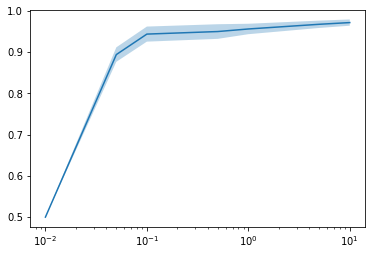

auc score :  0.9837350578091318
оптимальный гиперпараметр С :  10
Качество алгоритма с l2 регуляризацией:


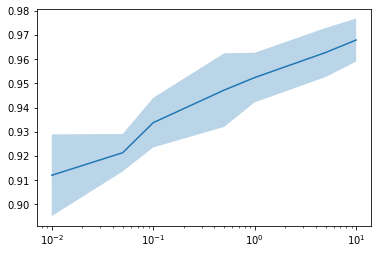

auc score :  0.9841269841269841
оптимальный гиперпараметр С :  10


In [23]:
print ("Качество алгоритма с l1 регуляризацией:")
     
plot_scores(grid_cv_l1)
print ("auc score : ",roc_auc_score(y_test,grid_cv_l1.predict_proba(X_test)[:,1]))
print ("оптимальный гиперпараметр С : ",grid_cv_l1.best_params_["C"])

print ("Качество алгоритма с l2 регуляризацией:")

plot_scores(grid_cv_l2)
print ("auc score : ",roc_auc_score(y_test,grid_cv_l2.predict_proba(X_test)[:,1]))
print ("оптимальный гиперпараметр С : ",grid_cv_l2.best_params_["C"])
plt.show()

In [24]:
l1_best = grid_cv_l1.best_estimator_
print (feat_coef(l1_best))

[('Normal', -4.6876775535303326), ('Bug', -4.316215341357188), ('Poison', -4.219413457533502), ('Attack', -3.4863331827524298), ('Dark', -2.477165554574854), ('Dragon', -2.4400571185968194), ('Fairy', -1.6687896231900816), ('Water', -1.1776567164152598), ('Ghost', -1.1136705954171076), ('Fighting', -0.9548063382317501), ('Ground', -0.21235011734298123), ('Sp. Atk', 0.0), ('Ice', 0.0), ('Grass', 0.4539048233998251), ('Defense', 0.5130415489298645), ('Fire', 0.6059065608306177), ('Steel', 0.6832922880174478), ('Electric', 1.1254973894579592), ('Psychic', 1.7390636351465343), ('Generation', 2.204564465587161), ('Flying', 2.2710773585845603), ('No second type', 2.3941631161517476), ('Rock', 2.6728849878379015), ('HP', 3.162011759953639), ('Sp. Def', 5.647771786499076), ('Speed', 8.835321002387971), ('Total', 35.25767701568173)]


* 4 признака с наибольшими по величине отрицательными коэффициентами {Normal,Bug,Poison,Attack}
* 4 признака с наибольшими по величине коэффициентами {Hp,Sp.Def,Speed,Total}
* признаки с нулевым значением коэффициента {Ice,Sp.Atk}

In [25]:
import seaborn as sns

In [26]:
X_concat = pd.concat([X_train,X_test],axis = 0)
y_concat = np.hstack((y_train,y_test))

X_concat["Legendary"] = y_concat

In [27]:
def many_kde(features,titles, shape):
    plt.figure(figsize=(shape[1]*5, shape[0]*5))
    i = 1
    for feature,title in zip(features,titles):
        ax = plt.subplot(shape[0], shape[1], i)
        ax.set_title(title)
        i += 1
        zero = X_concat.loc[X_concat["Legendary"] == 0]
        ones = X_concat.loc[X_concat["Legendary"] == 1]
        sns.kdeplot(zero[feature])
        sns.kdeplot(ones[feature])

In [28]:
def num_many_scatters(features,titles, shape):
    plt.figure(figsize=(shape[1]*5, shape[0]*5))
    i = 1
    for feature,title in zip(features,titles):
        ax = plt.subplot(shape[0], shape[1], i)
        ax.set_title(title)
        i += 1
        sns.boxplot(x = "Legendary",y = feature,hue = "Legendary",data = X_concat)

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


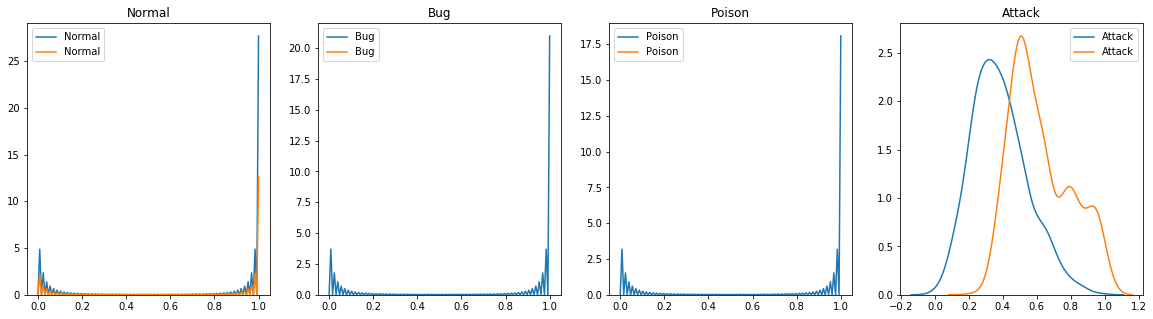

In [29]:
many_kde(["Normal","Bug","Poison","Attack"],["Normal","Bug","Poison","Attack"],(1,4))

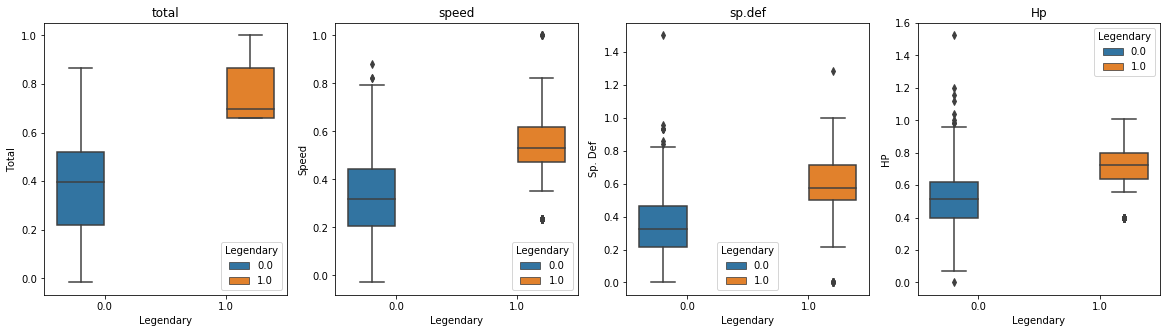

In [30]:
num_many_scatters([X_concat["Total"],X_concat["Speed"],X_concat["Sp. Def"],X_concat["HP"]]
              ,["total","speed","sp.def","Hp"],(1,4))

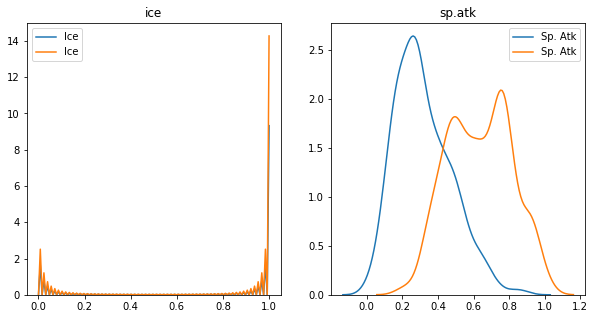

In [31]:
many_kde(["Ice","Sp. Atk"]
              ,["ice","sp.atk"],(1,2))

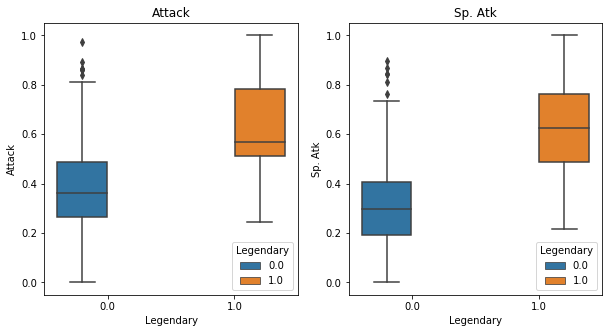

In [33]:
import seaborn as sns

num_many_scatters([X_concat["Attack"],X_concat["Sp. Atk"]]
              ,["Attack","Sp. Atk"],(1,2))

In [33]:
l2_best = grid_cv_l2.best_estimator_
print (feat_coef(l2_best))

[('Bug', -2.886319995157776), ('Normal', -2.7537292444703096), ('Poison', -2.3079622557043917), ('Ghost', -1.3279810768444191), ('Dark', -1.1517621878939714), ('Dragon', -1.1144332491360454), ('Fairy', -0.8119250109801566), ('Water', -0.39861375261009635), ('Ground', -0.03742459168620011), ('Fighting', 0.03419051590299772), ('Ice', 0.2975981746850834), ('Grass', 0.48253153849686636), ('Fire', 0.8597772610449237), ('Steel', 1.1141811239064752), ('Electric', 1.2940954162427378), ('Generation', 1.5783265312069308), ('Psychic', 1.884632215240399), ('Flying', 2.263472421198203), ('No second type', 2.273162524910037), ('Rock', 2.2911536281144156), ('Attack', 3.260002160533231), ('Sp. Atk', 4.744726878458576), ('Defense', 4.922466419074182), ('HP', 5.202259566252861), ('Sp. Def', 8.009396411259432), ('Speed', 9.058215808544496), ('Total', 9.982465662255038)]


* 4 признака с наибольшими по величине отрицательными коэффициентами {Normal,Bug,Poison,Ghost}
* 4 признака с наибольшими по величине коэффициентами {Hp,Sp.Def,Speed,Total}

* Результаты использования l1 и l2 регуляризации содержат некоторые расхождения.Отброшенные признаки оказываются значимыми в другой модели,их влияние на целевую метку удалось показать.В целом качество при использовании l2 регуляризации для нашей модели оказалось лучше.